In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint

In [2]:
df=pd.read_csv('Comcast_telecom_complaints_data.csv' ,parse_dates=['Date_month_year','Time'])
df.head(3)

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,2015-04-22,2019-10-20 15:53:50,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,04-08-15,2015-08-04,2019-10-20 10:22:56,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,2015-04-18,2019-10-20 09:55:47,Internet,Acworth,Georgia,30101,Closed,Yes


In [3]:
df.dtypes

Ticket #                               object
Customer Complaint                     object
Date                                   object
Date_month_year                datetime64[ns]
Time                           datetime64[ns]
Received Via                           object
City                                   object
State                                  object
Zip code                                int64
Status                                 object
Filing on Behalf of Someone            object
dtype: object

# Problem 1.1:

Provide the trend chart for the number of complaints at monthly and daily granularity levels.

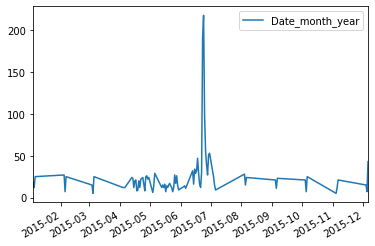

In [4]:
#trends of number of complaints at daily
df_days=pd.DataFrame(df['Date_month_year'].value_counts())
df_days.sort_index().plot()

In [5]:
#trends of number of complaints at monthly
df['Month_Year']=df['Date_month_year'].dt.to_period('M')
df_month=pd.DataFrame(df['Month_Year'].value_counts())

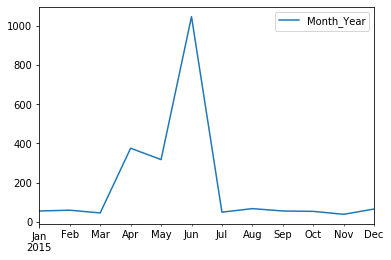

In [6]:
df_month.sort_index().plot()

# Problem 1.2

Provide a table with the frequency of complaint types. Which complaint types are maximum i.e., around internet, network issues, or across any other domains.

<b>this is a  problem of Topic Modeling which is a branch of NLP

In [7]:
data_text = df[['Customer Complaint']]
data_text['index'] = data_text.index
documents = data_text


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
print(len(documents))
print(documents[:5])

2224
                                  Customer Complaint  index
0                      Comcast Cable Internet Speeds      0
1       Payment disappear - service got disconnected      1
2                                  Speed and Service      2
3  Comcast Imposed a New Usage Cap of 300GB that ...      3
4         Comcast not working and no service to boot      4


In [9]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# wordnet for lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

In [10]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [12]:
import re
data=documents['Customer Complaint'].values.tolist()
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:5])

['Comcast Cable Internet Speeds',
 'Payment disappear - service got disconnected',
 'Speed and Service',
 'Comcast Imposed a New Usage Cap of 300GB that punishes streaming.',
 'Comcast not working and no service to boot']


In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:5])

[['comcast', 'cable', 'internet', 'speeds'], ['payment', 'disappear', 'service', 'got', 'disconnected'], ['speed', 'and', 'service'], ['comcast', 'imposed', 'new', 'usage', 'cap', 'of', 'gb', 'that', 'punishes', 'streaming'], ['comcast', 'not', 'working', 'and', 'no', 'service', 'to', 'boot']]


In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['comcast', 'cable', 'internet', 'speeds']


In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(text):
    texts_out=" ".join(lemma.lemmatize(word) for word in text)
    return texts_out

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
#create WordNetLemmatizer
lemma=WordNetLemmatizer()
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = [lemmatization(text).split() for text in data_words_bigrams]
print(data_lemmatized[:5])

[['comcast', 'cable', 'internet', 'speed'], ['payment', 'disappear', 'service', 'got', 'disconnected'], ['speed', 'service'], ['comcast', 'imposed', 'new', 'usage', 'cap', 'gb', 'punishes', 'streaming'], ['comcast', 'working', 'service', 'boot']]


In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(3, 1), (8, 1)], [(1, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(1, 1), (8, 1), (16, 1), (17, 1)], [(18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)], [(8, 1), (9, 1), (20, 1), (25, 1), (26, 1)], [(1, 1), (8, 1), (27, 1), (28, 1), (29, 1), (30, 1)], [(1, 1), (31, 1), (32, 1)], [(1, 1), (33, 1), (34, 1), (35, 1), (36, 1)]]


In [19]:
id2word[0]

'cable'

In [20]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('cable', 1), ('comcast', 1), ('internet', 1), ('speed', 1)]]

In [21]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.099*"price" + 0.061*"switch" + 0.060*"bait" + 0.049*"refund" + '
  '0.044*"availability" + 0.040*"account" + 0.026*"plan" + 0.021*"misleading" '
  '+ 0.019*"bandwidth" + 0.018*"gb"'),
 (1,
  '0.332*"billing" + 0.083*"false" + 0.041*"overcharge" + 0.033*"significant" '
  '+ 0.032*"reimburse" + 0.032*"admit" + 0.021*"unauthorized" + 0.017*"fraud" '
  '+ 0.012*"resolution" + 0.012*"improper"'),
 (2,
  '0.072*"charged" + 0.058*"fee" + 0.054*"usage" + 0.045*"contract" + '
  '0.037*"paying" + 0.030*"failure" + 0.029*"charging" + 0.024*"year" + '
  '0.022*"rate" + 0.021*"mb"'),
 (3,
  '0.118*"billing" + 0.107*"customer" + 0.077*"charge" + 0.075*"practice" + '
  '0.067*"unfair" + 0.058*"cable" + 0.042*"poor" + 0.028*"connectivity" + '
  '0.027*"modem" + 0.026*"quality"'),
 (4,
  '0.185*"bill" + 0.044*"fraudulent" + 0.030*"show" + 0.029*"incorrect" + '
  '0.026*"cramming" + 0.018*"promotion" + 0.018*"claim" + 0.014*"said" + '
  '0.014*"people" + 0.014*"way"'),
 (5,
  '0.364*"internet"

How to interpret this?
<br/>
Topic 0 is a represented as  '0.099*"price" + 0.061*"switch" + 0.060*"bait" + 0.049*"refund" + 0.044*"availability" + 0.040*"account" + 0.026*"plan" + 0.021*"misleading" + 0.019*"bandwidth" + 0.018*"gb"'
<br/>
It means the top 10 keywords that contribute to this topic are: ‘price’, ‘switch’, ‘bait’.. and so on and the weight of ‘price’ on topic 0 is 0.099.

<b>Compute Model Perplexity and Coherence Score

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.0493189615045155

Coherence Score:  0.6437856159124845


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.330406 -0.282726       1        1  25.779299
5     -0.236346  0.326419       2        1  18.202995
8     -0.023526  0.033560       3        1  13.030568
3      0.138331 -0.083893       4        1  11.012672
2      0.056845  0.014172       5        1   7.415119
6      0.054316  0.014959       6        1   6.550916
0      0.061315  0.012505       7        1   5.413440
1      0.138361 -0.055855       8        1   4.891561
4      0.070085  0.010623       9        1   4.172245
9      0.071024  0.010237      10        1   3.531190, topic_info=     Category         Freq          Term        Total  loglift  logprob
1     Default  1250.000000       comcast  1250.000000  30.0000  30.0000
8     Default   497.000000       service   497.000000  29.0000  29.0000
2     Default   529.000000      internet   529.000000  28.0000  28.0000
38    Default   233.000000       billing   233.000000  27.0000  27.0000
3     Default   185.000000         speed   185.000000  26.0000  26.0000
20    Default   176.000000          data   176.000000  25.0000  25.0000
9     Default   162.000000           cap   162.000000  24.0000  24.0000
69    Default    95.000000      customer    95.000000  23.0000  23.0000
148   Default    62.000000          bill    62.000000  22.0000  22.0000
79    Default   124.000000         issue   124.000000  21.0000  21.0000
189   Default    68.000000        charge    68.000000  20.0000  20.0000
71    Default    67.000000      practice    67.000000  19.0000  19.0000
25    Default    41.000000    throttling    41.000000  18.0000  18.0000
56    Default   107.000000     complaint   107.000000  17.0000  17.0000
201   Default    59.000000        unfair    59.000000  16.0000  16.0000
35    Default    43.000000         price    43.000000  15.0000  15.0000
87    Default    97.000000       xfinity    97.000000  14.0000  14.0000
309   Default    43.000000       charged    43.000000  13.0000  13.0000
0     Default    52.000000         cable    52.000000  12.0000  12.0000
115   Default    33.000000         false    33.000000  11.0000  11.0000
21    Default    34.000000           fee    34.000000  10.0000  10.0000
15    Default    33.000000         usage    33.000000   9.0000   9.0000
199   Default    38.000000          poor    38.000000   8.0000   8.0000
59    Default    29.000000     equipment    29.000000   7.0000   7.0000
73    Default    27.000000        switch    27.000000   6.0000   6.0000
72    Default    26.000000          bait    26.000000   5.0000   5.0000
213   Default    61.000000       pricing    61.000000   4.0000   4.0000
75    Default    27.000000      contract    27.000000   3.0000   3.0000
207   Default    24.000000   advertising    24.000000   2.0000   2.0000
281   Default    22.000000        refund    22.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
25    Topic10    40.464252    throttling    41.255089   3.3242  -1.9421
45    Topic10    13.836753        access    14.627610   3.2880  -3.0152
67    Topic10    12.367464      monopoly    13.158293   3.2816  -3.1275
1248  Topic10    12.150132        output    12.949055   3.2799  -3.1452
46    Topic10     9.622634      blocking    10.413448   3.2646  -3.3784
48    Topic10     8.295924        hbo_go     9.086734   3.2525  -3.5268
68    Topic10     7.860160          time     8.651039   3.2477  -3.5807
235   Topic10     6.684693             p     7.475500   3.2317  -3.7427
22    Topic10     5.447640           isp     6.238728   3.2079  -3.9474
968   Topic10     4.924959       ordered     5.716003   3.1946  -4.0482
139   Topic10     4.838786          much     5.629733   3.1921  -4.0659
271   Topic10     4.314110         hbogo     5.104919   3.1752  -4.1806
255   Topic10     3.822203       package     4.613070   3.1555  -4.3017
426   Topic10     3.337459        device     4.128268   3.1309  -4.43

# Problem 1.3

Create a new categorical variable with value as Open and Closed. Open & Pending is to be categorized as Open and Closed & Solved is to be categorized as Closed.

In [63]:
df['Status'].unique()

array(['Closed', 'Open', 'Solved', 'Pending'], dtype=object)

In [66]:
df['ModifiedStatus']=["Open" if status=='Open' or status=='Pending' else "Closed" for status in df['Status']]
df['ModifiedStatus'].head()

0    Closed
1    Closed
2    Closed
3      Open
4    Closed
Name: ModifiedStatus, dtype: object

#  Problem 1.4

Provide state wise status of complaints in a stacked bar chart. Use the categorized variable from Q3. Provide insights on:
<li>A.	Which state has the maximum complaints</li>
<li>B.	Which state has the highest percentage of unresolved complaints</li>


In [75]:
#A. which state has the maximum complaints
df_statewise_complaints=df.groupby(["State"]).size().sort_values(ascending=False).to_frame().reset_index().rename({0: "Count"}, axis=1)
df_statewise_complaints.head(10)

,State,Count
0,Georgia,288
1,Florida,240
2,California,220
3,Illinois,164
4,Tennessee,143
5,Pennsylvania,130
6,Michigan,115
7,Washington,98
8,Colorado,80
9,Maryland,78


In [76]:
#state having maximum complaints
df_statewise_complaints['State'][0]

'Georgia'

In [77]:
#B.Which state has the highest percentage of unresolved complaints
status_complaints = df.groupby(["State", "ModifiedStatus"]).size().unstack()
status_complaints

ModifiedStatus,Closed,Open
State,,
Alabama,17.0,9.0
Arizona,14.0,6.0
Arkansas,6.0,NaN
California,159.0,61.0
Colorado,58.0,22.0
Connecticut,9.0,3.0
Delaware,8.0,4.0
District Of Columbia,14.0,2.0
District of Columbia,1.0,NaN


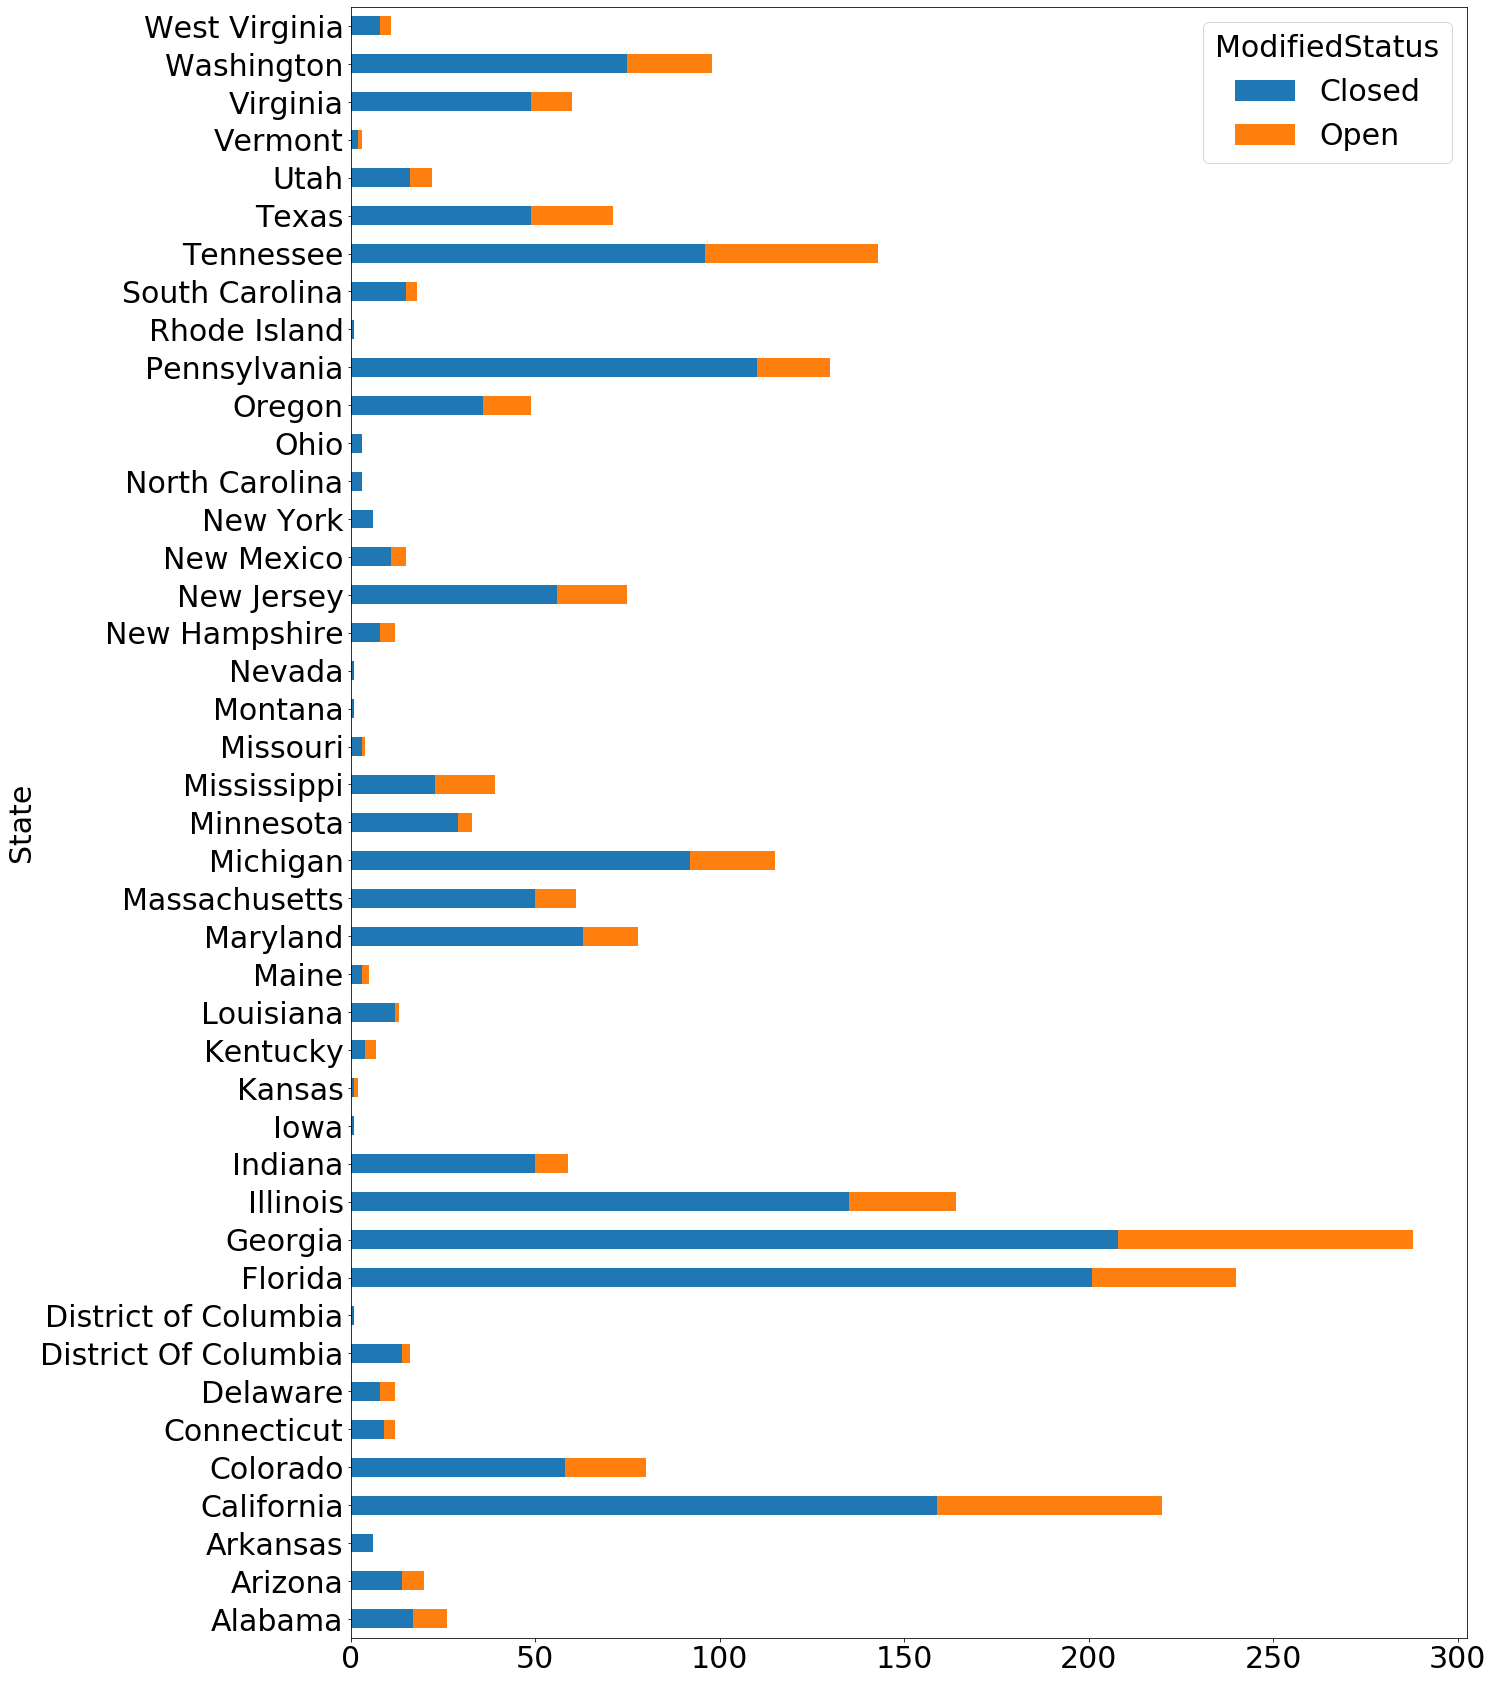

In [92]:
status_complaints=status_complaints.fillna(0)
status_complaints.plot(kind="barh", figsize=(20,30), stacked=True)
plt.rcParams.update({"font.size": 30})

In [91]:
status_complaints.loc[status_complaints['Open'].idxmax()].name

'Georgia'

# Problem 1.4

Provide the percentage of complaints resolved till date, which were received through the Internet and customer care calls.

In [96]:
status_received_via = df.groupby(["Received Via", "ModifiedStatus"]).size().unstack()
status_received_via['% of Resolved']=100*status_received_via['Closed']/(status_received_via['Closed']+status_received_via['Open'])
status_received_via

ModifiedStatus,Closed,Open,% of Resolved
Received Via,,,
Customer Care Call,864,255,77.211796
Internet,843,262,76.289593
